## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import logging
import itertools
import warnings

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from datasets import Dataset, DatasetDict


import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

import useful_rdkit_utils as uru
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

In [3]:
plt.style.use(["science"])

In [4]:
%matplotlib inline

In [5]:
# setup tqdm
tqdm.pandas()

In [6]:
# setup logging
level = logging.DEBUG
logger = logging.getLogger(__name__)
if logger.hasHandlers():
    logger.handlers.clear()

formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
ch = logging.StreamHandler()
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.setLevel(level)

logger.info("Imports successful.")

2025-11-16 17:14:52,552 - __main__ - INFO - Imports successful.


## Load Data

In [7]:
# Data input and output directories
base_data_dir = Path().cwd().parents[0] / "assets/dataset/eda/data/set"
output_dir = base_data_dir.parents[2] / "splits"
output_dir.mkdir(parents=True, exist_ok=True)

output_fig_dir = output_dir / "figures"
output_fig_dir.mkdir(parents=True, exist_ok=True)

if not base_data_dir.exists():
    raise FileNotFoundError(f"Data directory not found at {base_data_dir}")

logger.info(f"Output directory set to {output_dir}")
logger.info(f"Input data directory found at {base_data_dir}")
for dataset_dir in base_data_dir.iterdir():
    logger.info(f"Dataset name: {dataset_dir.name}")

2025-11-16 17:14:52,581 - __main__ - INFO - Output directory set to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits
2025-11-16 17:14:52,581 - __main__ - INFO - Input data directory found at /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/eda/data/set
2025-11-16 17:14:52,581 - __main__ - INFO - Dataset name: cleaned_combined_datasets_low_quality_summary_table.csv
2025-11-16 17:14:52,582 - __main__ - INFO - Dataset name: cleaned_combined_datasets_medium_quality_summary_table.csv
2025-11-16 17:14:52,582 - __main__ - INFO - Dataset name: cleaned_combined_datasets_medium_quality.csv
2025-11-16 17:14:52,582 - __main__ - INFO - Dataset name: cleaned_combined_datasets_low_medium_high_quality.csv
2025-11-16 17:14:52,582 - __main__ - INFO - Dataset name: cleaned_combined_datasets_high_quality.csv
2025-11-16 17:14:52,582 - __main__ - INFO - Dataset name: cleaned

In [8]:
# Load input datasets
datasets = {
    "high": pd.read_csv(base_data_dir / "cleaned_combined_datasets_high_quality.csv"),
    "medium": pd.read_csv(
        base_data_dir / "cleaned_combined_datasets_medium_high_quality.csv", low_memory=False
    ),
    "low": pd.read_csv(
        base_data_dir / "cleaned_combined_datasets_low_medium_high_quality.csv", low_memory=False
    ),
}

for name, df in datasets.items():
    logger.info(f"Dataset: {name}, shape: {df.shape}")
    logger.info(f"Columns: {df.columns.tolist()}")
    logger.info(f"Unique Dataset Constituents: {df['Dataset'].unique()}")

2025-11-16 17:14:52,814 - __main__ - INFO - Dataset: high, shape: (5326, 12)
2025-11-16 17:14:52,814 - __main__ - INFO - Columns: ['Molecule Name', 'SMILES', 'Dataset', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint', 'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB', 'MBPB', 'MGMB']
2025-11-16 17:14:52,815 - __main__ - INFO - Unique Dataset Constituents: ['expansionrx']
2025-11-16 17:14:52,815 - __main__ - INFO - Dataset: medium, shape: (94708, 12)
2025-11-16 17:14:52,815 - __main__ - INFO - Columns: ['Molecule Name', 'SMILES', 'Dataset', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint', 'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB', 'MBPB', 'MGMB']
2025-11-16 17:14:52,818 - __main__ - INFO - Unique Dataset Constituents: ['expansionrx' 'kermt_public']
2025-11-16 17:14:52,818 - __main__ - INFO - Dataset: low, shape: (116527, 12)
2025-11-16 17:14:52,819 - __main__ - INFO - Columns: ['Molecule Name', 'SMILES', 'Dataset', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint'

In [9]:
# calculate fingerprints for all molecules in each dataset
fpgen = rdFingerprintGenerator.GetMorganGenerator(
    radius=3,
    countSimulation=False,
    includeChirality=False,
    fpSize=2048,
)

for name, df in datasets.items():
    logger.info(f"Calculating fingerprints for dataset: {name}")
    df["mol"] = df["SMILES"].progress_apply(Chem.MolFromSmiles)
    df["Fingerprint"] = df["mol"].progress_apply(fpgen.GetCountFingerprintAsNumPy)

    df.drop(columns=["mol"], inplace=True)

    # put fingerprint column after "Molecule Name,SMILES,Dataset"
    cols = df.columns.tolist()
    cols.insert(3, cols.pop(cols.index("Fingerprint")))
    df = df[cols]

    # expand fingerprint numpy arrays into separate columns
    fp_array = np.vstack(df["Fingerprint"].values)
    fp_df = pd.DataFrame(fp_array, columns=[f"Morgan_FP_{i}" for i in range(fp_array.shape[1])])
    df = pd.concat([df.reset_index(drop=True), fp_df.reset_index(drop=True)], axis=1)
    df.drop(columns=["Fingerprint"], inplace=True)
    logger.debug(f"Number of fingerprint columns added: {fp_df.shape[1]}")

    datasets[name] = df
    logger.info(f"Fingerprints calculated for dataset: {name}")
    logger.debug(f"Dataset {name} columns after fingerprint calculation: {df.columns.tolist()}")

2025-11-16 17:14:52,865 - __main__ - INFO - Calculating fingerprints for dataset: high


  0%|          | 0/5326 [00:00<?, ?it/s]

  0%|          | 0/5326 [00:00<?, ?it/s]

2025-11-16 17:14:54,241 - __main__ - DEBUG - Number of fingerprint columns added: 2048
2025-11-16 17:14:54,241 - __main__ - INFO - Fingerprints calculated for dataset: high
2025-11-16 17:14:54,241 - __main__ - DEBUG - Dataset high columns after fingerprint calculation: ['Molecule Name', 'SMILES', 'Dataset', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint', 'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB', 'MBPB', 'MGMB', 'Morgan_FP_0', 'Morgan_FP_1', 'Morgan_FP_2', 'Morgan_FP_3', 'Morgan_FP_4', 'Morgan_FP_5', 'Morgan_FP_6', 'Morgan_FP_7', 'Morgan_FP_8', 'Morgan_FP_9', 'Morgan_FP_10', 'Morgan_FP_11', 'Morgan_FP_12', 'Morgan_FP_13', 'Morgan_FP_14', 'Morgan_FP_15', 'Morgan_FP_16', 'Morgan_FP_17', 'Morgan_FP_18', 'Morgan_FP_19', 'Morgan_FP_20', 'Morgan_FP_21', 'Morgan_FP_22', 'Morgan_FP_23', 'Morgan_FP_24', 'Morgan_FP_25', 'Morgan_FP_26', 'Morgan_FP_27', 'Morgan_FP_28', 'Morgan_FP_29', 'Morgan_FP_30', 'Morgan_FP_31', 'Morgan_FP_32', 'Morgan_FP_33', 'Morgan_FP_34', 'Morgan_FP_35

  0%|          | 0/94708 [00:00<?, ?it/s]

  0%|          | 0/94708 [00:00<?, ?it/s]

2025-11-16 17:15:14,908 - __main__ - DEBUG - Number of fingerprint columns added: 2048
2025-11-16 17:15:14,908 - __main__ - INFO - Fingerprints calculated for dataset: medium
2025-11-16 17:15:14,909 - __main__ - DEBUG - Dataset medium columns after fingerprint calculation: ['Molecule Name', 'SMILES', 'Dataset', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint', 'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB', 'MBPB', 'MGMB', 'Morgan_FP_0', 'Morgan_FP_1', 'Morgan_FP_2', 'Morgan_FP_3', 'Morgan_FP_4', 'Morgan_FP_5', 'Morgan_FP_6', 'Morgan_FP_7', 'Morgan_FP_8', 'Morgan_FP_9', 'Morgan_FP_10', 'Morgan_FP_11', 'Morgan_FP_12', 'Morgan_FP_13', 'Morgan_FP_14', 'Morgan_FP_15', 'Morgan_FP_16', 'Morgan_FP_17', 'Morgan_FP_18', 'Morgan_FP_19', 'Morgan_FP_20', 'Morgan_FP_21', 'Morgan_FP_22', 'Morgan_FP_23', 'Morgan_FP_24', 'Morgan_FP_25', 'Morgan_FP_26', 'Morgan_FP_27', 'Morgan_FP_28', 'Morgan_FP_29', 'Morgan_FP_30', 'Morgan_FP_31', 'Morgan_FP_32', 'Morgan_FP_33', 'Morgan_FP_34', 'Morgan_F

  0%|          | 0/116527 [00:00<?, ?it/s]

  0%|          | 0/116527 [00:00<?, ?it/s]

2025-11-16 17:15:39,643 - __main__ - DEBUG - Number of fingerprint columns added: 2048
2025-11-16 17:15:39,644 - __main__ - INFO - Fingerprints calculated for dataset: low
2025-11-16 17:15:39,644 - __main__ - DEBUG - Dataset low columns after fingerprint calculation: ['Molecule Name', 'SMILES', 'Dataset', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint', 'Caco-2 Permeability Efflux', 'MPPB', 'Caco-2 Permeability Papp A>B', 'MBPB', 'MGMB', 'Morgan_FP_0', 'Morgan_FP_1', 'Morgan_FP_2', 'Morgan_FP_3', 'Morgan_FP_4', 'Morgan_FP_5', 'Morgan_FP_6', 'Morgan_FP_7', 'Morgan_FP_8', 'Morgan_FP_9', 'Morgan_FP_10', 'Morgan_FP_11', 'Morgan_FP_12', 'Morgan_FP_13', 'Morgan_FP_14', 'Morgan_FP_15', 'Morgan_FP_16', 'Morgan_FP_17', 'Morgan_FP_18', 'Morgan_FP_19', 'Morgan_FP_20', 'Morgan_FP_21', 'Morgan_FP_22', 'Morgan_FP_23', 'Morgan_FP_24', 'Morgan_FP_25', 'Morgan_FP_26', 'Morgan_FP_27', 'Morgan_FP_28', 'Morgan_FP_29', 'Morgan_FP_30', 'Morgan_FP_31', 'Morgan_FP_32', 'Morgan_FP_33', 'Morgan_FP_34', 'Morgan_FP_35',

In [10]:
# on high-quality dataset, sort by Molecule Name ascending and split test/train by first 90%/10%
percentage_train = 0.9
percentage_validation = 0.1

high_quality_df = datasets["high"].sort_values(by="Molecule Name").reset_index(drop=True)
n_total = high_quality_df.shape[0]
n_train = int(n_total * percentage_train)
n_test = n_total - n_train

test_df = high_quality_df.iloc[n_train:]
train_df = high_quality_df.iloc[:n_train]

# randomly split train into train/validation sets
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
n_validation = int(train_df.shape[0] * percentage_validation)
validation_df = train_df.iloc[:n_validation]
train_df = train_df.iloc[n_validation:]


logger.info(f"High-quality dataset total samples: {n_total}")
logger.info(f"Training samples: {train_df.shape[0]}")
logger.info(f"Validation samples: {validation_df.shape[0]}")
logger.info(f"Testing samples: {test_df.shape[0]}")

# save to temporal datasplit
temporal_dir = output_dir / "high_quality/temporal_split"
temporal_dir.mkdir(parents=True, exist_ok=True)

# convert to hf dataset and save
train_hf = Dataset.from_pandas(train_df, preserve_index=False)
validation_hf = Dataset.from_pandas(validation_df, preserve_index=False)
test_hf = Dataset.from_pandas(test_df, preserve_index=False)
temporal_hf = DatasetDict({"train": train_hf, "validation": validation_hf, "test": test_hf})
# save to disk
temporal_hf.save_to_disk(str(temporal_dir))
logger.info(f"Temporal split datasets saved to {temporal_dir}")

2025-11-16 17:15:39,760 - __main__ - INFO - High-quality dataset total samples: 5326
2025-11-16 17:15:39,760 - __main__ - INFO - Training samples: 4314
2025-11-16 17:15:39,761 - __main__ - INFO - Validation samples: 479
2025-11-16 17:15:39,761 - __main__ - INFO - Testing samples: 533


Saving the dataset (0/1 shards):   0%|          | 0/4314 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/479 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/533 [00:00<?, ? examples/s]

2025-11-16 17:15:42,610 - __main__ - INFO - Temporal split datasets saved to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/temporal_split


In [ ]:
n_folds = 5
n_splits = 5
percentage_validation = 0.1
stratify_column = "Dataset"

split_dict = {
    "random_cluster": uru.get_random_clusters,
    "scaffold_cluster": uru.get_bemis_murcko_clusters,
    "kmeans_cluster": uru.get_kmeans_clusters,  # n_clusters = 10 by default
    "butina_cluster": uru.get_butina_clusters,  # cutoff = 0.65 by default
    # "umap_cluster": uru.get_umap_clusters,
}

In [12]:
split_datasets = {}

n_iter = len(datasets) * len(split_dict) * n_splits
logger.info(f"Total iterations for dataset splits: {n_iter}")

pbar = tqdm(total=n_iter, desc="Creating dataset splits")
for dset_name, data in datasets.items():  # iterate over different datasets
    split_datasets[dset_name] = {}

    for split_name, split in split_dict.items():  # iterate over different splitting methods
        logger.info(f"Processing dataset: {dset_name} with split method: {split_name}")
        split_datasets[dset_name][split_name] = {}

        for i in range(0, n_splits):  # iterate over different splits
            split_datasets[dset_name][split_name][f"split_{i}"] = {}
            group_kfold_shuffle = uru.GroupKFoldShuffle(n_splits=n_folds, random_state=i, shuffle=True)

            for group in data[stratify_column].unique():  # iterate over different dataset groups
                # stratified group k-fold split (based on "Dataset" column)
                subdata = data[data[stratify_column] == group]
                cluster_list = split(subdata.SMILES)

                # make fictitious subdata indices to map back to original data later
                subdata_indices = subdata.index.to_numpy()

                # iterate over different folds within each split
                for j, (subdata_train_idx, subdata_test_idx) in enumerate(
                    group_kfold_shuffle.split(subdata_indices, groups=cluster_list)
                ):
                    if f"fold_{j}" not in split_datasets[dset_name][split_name][f"split_{i}"]:
                        split_datasets[dset_name][split_name][f"split_{i}"][f"fold_{j}"] = {}

                    # map indices back to original data
                    train_idx = subdata_indices[subdata_train_idx]
                    test_idx = subdata_indices[subdata_test_idx]

                    # further split train_idx into train and validation sets
                    n_train_samples = len(train_idx)
                    n_val_samples = int(n_train_samples * percentage_validation)
                    np.random.seed(i + j)  # ensure reproducibility
                    shuffled_train_idx = np.random.permutation(train_idx)
                    val_idx = shuffled_train_idx[:n_val_samples]
                    train_idx = shuffled_train_idx[n_val_samples:]

                    # save indices for each group split
                    split_datasets[dset_name][split_name][f"split_{i}"][f"fold_{j}"][group] = {
                        "train": train_idx,
                        "validation": val_idx,
                        "test": test_idx,
                    }

            pbar.update(1)

            # combine group splits into final train/test sets for each fold
            # logger.debug(f"Combining group splits for dataset: {dset_name}, split: {split_name}, iteration: {i}")
            for j in range(n_folds):
                if f"fold_{j}" not in split_datasets[dset_name][split_name][f"split_{i}"]:
                    raise ValueError(
                        f"Fold {j} not found in split {i} for dataset {dset_name} and split method {split_name}"
                    )

                combined_train_indices = []
                combined_val_indices = []
                combined_test_indices = []

                for group in data[stratify_column].unique():
                    group_split = split_datasets[dset_name][split_name][f"split_{i}"][f"fold_{j}"][group]
                    combined_train_indices.extend(group_split["train"])
                    combined_val_indices.extend(group_split["validation"])
                    combined_test_indices.extend(group_split["test"])

                combined_train_indices = np.array(combined_train_indices)
                combined_val_indices = np.array(combined_val_indices)
                combined_test_indices = np.array(combined_test_indices)

                # save combined train/test sets
                split_datasets[dset_name][split_name][f"split_{i}"][f"fold_{j}"]["total"] = {
                    "train": combined_train_indices,
                    "validation": combined_val_indices,
                    "test": combined_test_indices,
                }

                # final assertions


pbar.close()

2025-11-16 17:15:42,675 - __main__ - INFO - Total iterations for dataset splits: 15


Creating dataset splits:   0%|          | 0/15 [00:00<?, ?it/s]

2025-11-16 17:15:42,679 - __main__ - INFO - Processing dataset: high with split method: random_cluster
2025-11-16 17:15:42,713 - __main__ - INFO - Processing dataset: medium with split method: random_cluster
2025-11-16 17:15:44,433 - __main__ - INFO - Processing dataset: low with split method: random_cluster


In [13]:
# save all datasets with name format {dataset}_quality/{split_method}/split{split_number}_fold{fold_number}.csv
for dset_name, splits in split_datasets.items():
    for split_name, split_data in splits.items():
        for split_number, folds in split_data.items():
            for fold_number, datasets_dict in folds.items():

                split_output_dir = (
                    output_dir / f"{dset_name}_quality/{split_name}/{split_number}/{fold_number}"
                )
                split_output_dir.mkdir(parents=True, exist_ok=True)
                logger.debug(f"Saving dataset to {split_output_dir}")

                train_idx = datasets_dict["total"]["train"]
                val_idx = datasets_dict["total"]["validation"]
                test_idx = datasets_dict["total"]["test"]

                # convert pandas to HF dataset
                train_hf = Dataset.from_pandas(data.loc[train_idx], preserve_index=False)
                val_hf = Dataset.from_pandas(data.loc[val_idx], preserve_index=False)
                test_hf = Dataset.from_pandas(data.loc[test_idx], preserve_index=False)
                dset = DatasetDict({"train": train_hf, "validation": val_hf, "test": test_hf})

                # Save to disk as HF dataset
                dset.save_to_disk(f"{split_output_dir}/hf_dataset")

        # print size of folder in MB after saving all splits
        folder_size = sum(f.stat().st_size for f in split_output_dir.glob("**/*") if f.is_file())
        folder_size_mb = folder_size / (1024 * 1024)
        logger.info(
            f"Saved all splits for dataset: {dset_name}, split method: {split_name}. Folder size: {folder_size_mb:.2f} MB"
        )

2025-11-16 17:15:46,745 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_0/fold_0


Saving the dataset (0/1 shards):   0%|          | 0/3834 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1066 [00:00<?, ? examples/s]

2025-11-16 17:15:49,595 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_0/fold_1


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:15:52,510 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_0/fold_2


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:15:55,412 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_0/fold_3


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:15:58,334 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_0/fold_4


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:01,260 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_1/fold_0


Saving the dataset (0/1 shards):   0%|          | 0/3834 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1066 [00:00<?, ? examples/s]

2025-11-16 17:16:04,148 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_1/fold_1


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:07,063 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_1/fold_2


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:09,959 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_1/fold_3


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:12,935 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_1/fold_4


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:15,882 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_2/fold_0


Saving the dataset (0/1 shards):   0%|          | 0/3834 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1066 [00:00<?, ? examples/s]

2025-11-16 17:16:18,784 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_2/fold_1


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:21,747 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_2/fold_2


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:24,637 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_2/fold_3


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:27,592 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_2/fold_4


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:30,552 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_3/fold_0


Saving the dataset (0/1 shards):   0%|          | 0/3834 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1066 [00:00<?, ? examples/s]

2025-11-16 17:16:33,459 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_3/fold_1


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:36,427 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_3/fold_2


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:39,359 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_3/fold_3


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:42,339 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_3/fold_4


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:45,299 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_4/fold_0


Saving the dataset (0/1 shards):   0%|          | 0/3834 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1066 [00:00<?, ? examples/s]

2025-11-16 17:16:48,241 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_4/fold_1


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:51,141 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_4/fold_2


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:54,147 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_4/fold_3


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:16:57,106 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/high_quality/random_cluster/split_4/fold_4


Saving the dataset (0/1 shards):   0%|          | 0/3835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1065 [00:00<?, ? examples/s]

2025-11-16 17:17:00,064 - __main__ - INFO - Saved all splits for dataset: high, split method: random_cluster. Folder size: 44.10 MB
2025-11-16 17:17:00,064 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_0/fold_0


Saving the dataset (0/2 shards):   0%|          | 0/68189 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18943 [00:00<?, ? examples/s]

2025-11-16 17:17:09,571 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_0/fold_1


Saving the dataset (0/2 shards):   0%|          | 0/68190 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18942 [00:00<?, ? examples/s]

2025-11-16 17:17:19,446 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_0/fold_2


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:17:29,272 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_0/fold_3


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:17:39,129 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_0/fold_4


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:17:48,857 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_1/fold_0


Saving the dataset (0/2 shards):   0%|          | 0/68189 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18943 [00:00<?, ? examples/s]

2025-11-16 17:17:58,663 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_1/fold_1


Saving the dataset (0/2 shards):   0%|          | 0/68190 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18942 [00:00<?, ? examples/s]

2025-11-16 17:18:08,431 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_1/fold_2


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:18:18,231 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_1/fold_3


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:18:28,157 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_1/fold_4


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:18:37,923 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_2/fold_0


Saving the dataset (0/2 shards):   0%|          | 0/68189 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18943 [00:00<?, ? examples/s]

2025-11-16 17:18:47,570 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_2/fold_1


Saving the dataset (0/2 shards):   0%|          | 0/68190 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18942 [00:00<?, ? examples/s]

2025-11-16 17:18:57,294 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_2/fold_2


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:19:07,065 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_2/fold_3


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:19:16,966 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_2/fold_4


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:19:26,779 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_3/fold_0


Saving the dataset (0/2 shards):   0%|          | 0/68189 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18943 [00:00<?, ? examples/s]

2025-11-16 17:19:36,534 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_3/fold_1


Saving the dataset (0/2 shards):   0%|          | 0/68190 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18942 [00:00<?, ? examples/s]

2025-11-16 17:19:46,334 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_3/fold_2


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:19:56,265 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_3/fold_3


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:20:06,067 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_3/fold_4


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:20:15,988 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_4/fold_0


Saving the dataset (0/2 shards):   0%|          | 0/68189 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18943 [00:00<?, ? examples/s]

2025-11-16 17:20:25,621 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_4/fold_1


Saving the dataset (0/2 shards):   0%|          | 0/68190 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18942 [00:00<?, ? examples/s]

2025-11-16 17:20:35,559 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_4/fold_2


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:20:45,429 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_4/fold_3


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:20:55,345 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/medium_quality/random_cluster/split_4/fold_4


Saving the dataset (0/2 shards):   0%|          | 0/68191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18941 [00:00<?, ? examples/s]

2025-11-16 17:21:05,142 - __main__ - INFO - Saved all splits for dataset: medium, split method: random_cluster. Folder size: 763.04 MB
2025-11-16 17:21:05,142 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_0/fold_0


Saving the dataset (0/2 shards):   0%|          | 0/83898 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23308 [00:00<?, ? examples/s]

2025-11-16 17:21:16,611 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_0/fold_1


Saving the dataset (0/2 shards):   0%|          | 0/83900 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23306 [00:00<?, ? examples/s]

2025-11-16 17:21:28,279 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_0/fold_2


Saving the dataset (0/2 shards):   0%|          | 0/83901 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23305 [00:00<?, ? examples/s]

2025-11-16 17:21:39,891 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_0/fold_3


Saving the dataset (0/2 shards):   0%|          | 0/83902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23304 [00:00<?, ? examples/s]

2025-11-16 17:21:51,569 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_0/fold_4


Saving the dataset (0/2 shards):   0%|          | 0/83902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23304 [00:00<?, ? examples/s]

2025-11-16 17:22:03,369 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_1/fold_0


Saving the dataset (0/2 shards):   0%|          | 0/83898 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23308 [00:00<?, ? examples/s]

2025-11-16 17:22:14,914 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_1/fold_1


Saving the dataset (0/2 shards):   0%|          | 0/83900 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23306 [00:00<?, ? examples/s]

2025-11-16 17:22:26,641 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_1/fold_2


Saving the dataset (0/2 shards):   0%|          | 0/83901 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23305 [00:00<?, ? examples/s]

2025-11-16 17:22:38,305 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_1/fold_3


Saving the dataset (0/2 shards):   0%|          | 0/83902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23304 [00:00<?, ? examples/s]

2025-11-16 17:22:49,999 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_1/fold_4


Saving the dataset (0/2 shards):   0%|          | 0/83902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23304 [00:00<?, ? examples/s]

2025-11-16 17:23:01,829 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_2/fold_0


Saving the dataset (0/2 shards):   0%|          | 0/83898 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23308 [00:00<?, ? examples/s]

2025-11-16 17:23:13,374 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_2/fold_1


Saving the dataset (0/2 shards):   0%|          | 0/83900 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23306 [00:00<?, ? examples/s]

2025-11-16 17:23:25,075 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_2/fold_2


Saving the dataset (0/2 shards):   0%|          | 0/83901 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23305 [00:00<?, ? examples/s]

2025-11-16 17:23:36,790 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_2/fold_3


Saving the dataset (0/2 shards):   0%|          | 0/83902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23304 [00:00<?, ? examples/s]

2025-11-16 17:23:48,483 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_2/fold_4


Saving the dataset (0/2 shards):   0%|          | 0/83902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23304 [00:00<?, ? examples/s]

2025-11-16 17:24:00,181 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_3/fold_0


Saving the dataset (0/2 shards):   0%|          | 0/83898 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23308 [00:00<?, ? examples/s]

2025-11-16 17:24:11,885 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_3/fold_1


Saving the dataset (0/2 shards):   0%|          | 0/83900 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23306 [00:00<?, ? examples/s]

2025-11-16 17:24:23,597 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_3/fold_2


Saving the dataset (0/2 shards):   0%|          | 0/83901 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23305 [00:00<?, ? examples/s]

2025-11-16 17:24:35,328 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_3/fold_3


Saving the dataset (0/2 shards):   0%|          | 0/83902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23304 [00:00<?, ? examples/s]

2025-11-16 17:24:47,013 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_3/fold_4


Saving the dataset (0/2 shards):   0%|          | 0/83902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23304 [00:00<?, ? examples/s]

2025-11-16 17:24:58,875 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_4/fold_0


Saving the dataset (0/2 shards):   0%|          | 0/83898 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23308 [00:00<?, ? examples/s]

2025-11-16 17:25:10,557 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_4/fold_1


Saving the dataset (0/2 shards):   0%|          | 0/83900 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23306 [00:00<?, ? examples/s]

2025-11-16 17:25:22,440 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_4/fold_2


Saving the dataset (0/2 shards):   0%|          | 0/83901 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23305 [00:00<?, ? examples/s]

2025-11-16 17:25:34,349 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_4/fold_3


Saving the dataset (0/2 shards):   0%|          | 0/83902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23304 [00:00<?, ? examples/s]

2025-11-16 17:25:46,270 - __main__ - DEBUG - Saving dataset to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/splits/low_quality/random_cluster/split_4/fold_4


Saving the dataset (0/2 shards):   0%|          | 0/83902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9321 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23304 [00:00<?, ? examples/s]

2025-11-16 17:25:58,185 - __main__ - INFO - Saved all splits for dataset: low, split method: random_cluster. Folder size: 938.38 MB


2025-11-16 17:25:58,227 - __main__ - INFO - Creating boxplot for dataset: high
2025-11-16 17:25:58,968 - __main__ - INFO - Creating boxplot for dataset: medium
2025-11-16 17:25:59,816 - __main__ - INFO - Creating boxplot for dataset: low


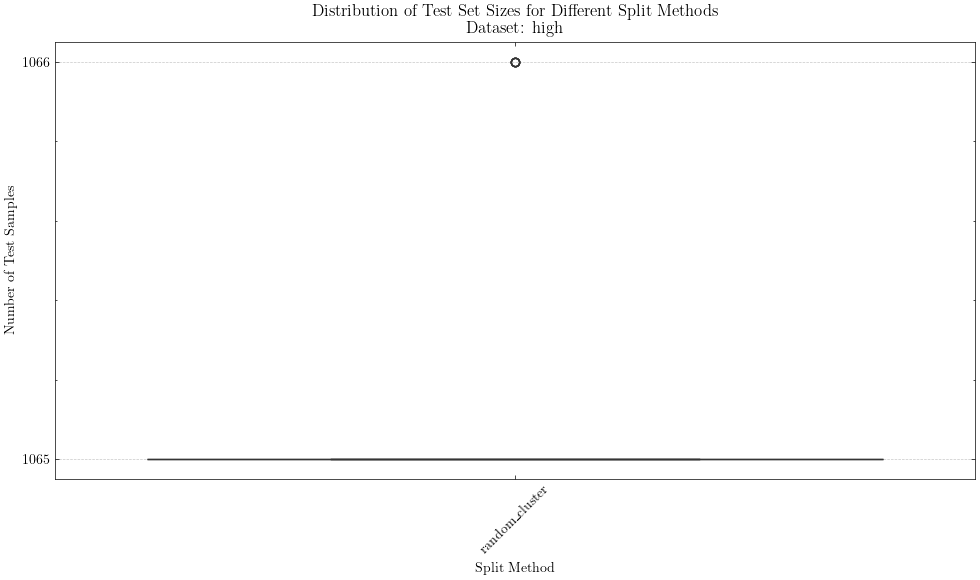

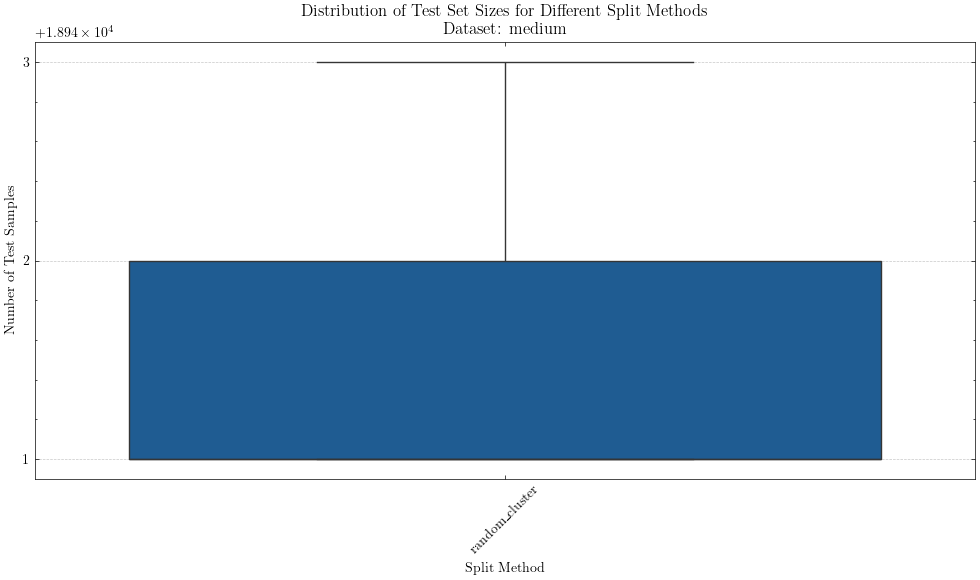

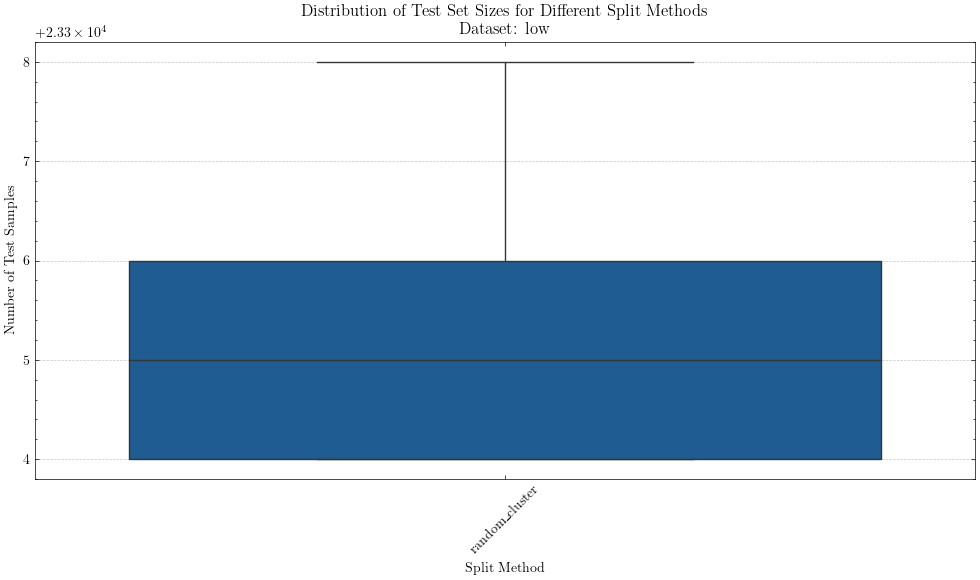

In [14]:
# boxplot for number of test samples for each split method (x) on different datasets (separate plots)
for dset_name, splits in split_datasets.items():
    logger.info(f"Creating boxplot for dataset: {dset_name}")

    plot_data = []
    for split_name, split_data in splits.items():
        for split_id, folds in split_data.items():
            for fold_id, datasets in folds.items():
                n_test_samples = len(datasets["total"]["test"])
                plot_data.append({"Split Method": split_name, "Number of Test Samples": n_test_samples})
    plot_df = pd.DataFrame(plot_data)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x="Split Method", y="Number of Test Samples", data=plot_df, ax=ax)
    ax.set_title(f"Distribution of Test Set Sizes for Different Split Methods\nDataset: {dset_name}")
    ax.set_ylabel("Number of Test Samples")
    ax.set_xlabel("Split Method")
    ax.yaxis.get_major_locator().set_params(integer=True)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True, axis="y", linestyle="--", alpha=0.7)

    fig.tight_layout()
    fig.savefig(output_fig_dir / f"{dset_name}_test_set_size_distribution.png", dpi=600)

2025-11-16 17:26:00,746 - __main__ - INFO - Creating train/test size distribution boxplots for dataset: high, split method: random_cluster
2025-11-16 17:26:01,593 - __main__ - INFO - Creating train/test size distribution boxplots for dataset: medium, split method: random_cluster
2025-11-16 17:26:02,512 - __main__ - INFO - Creating train/test size distribution boxplots for dataset: low, split method: random_cluster


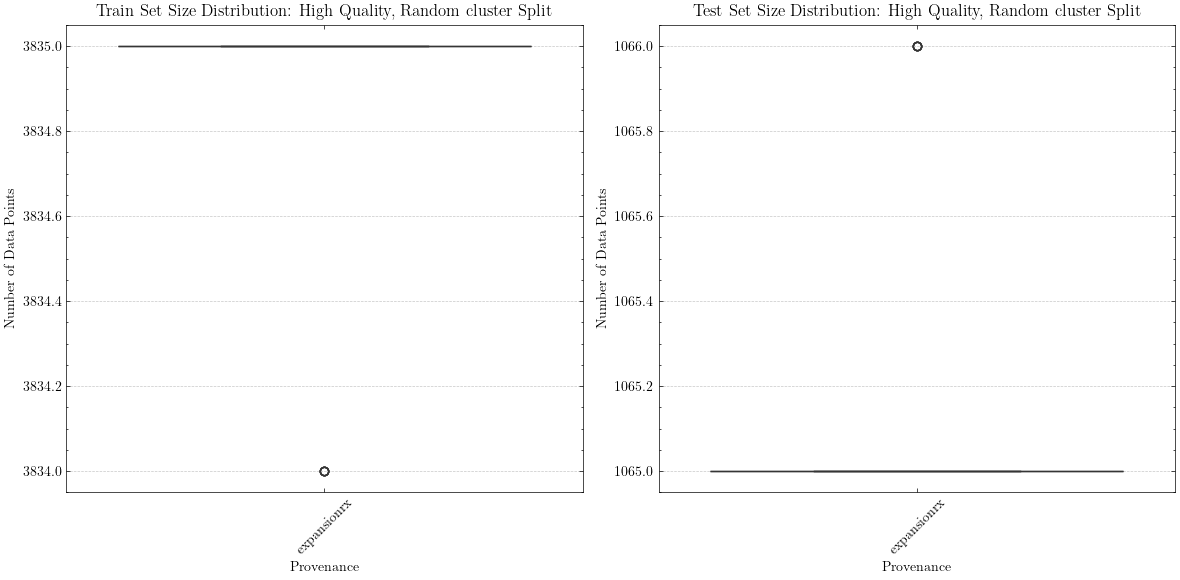

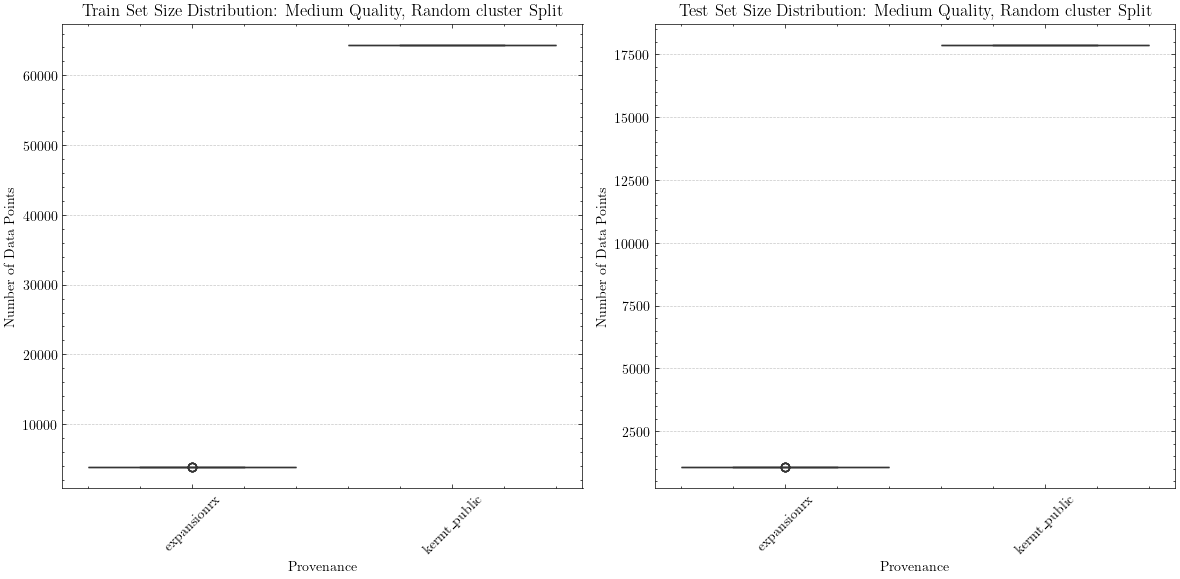

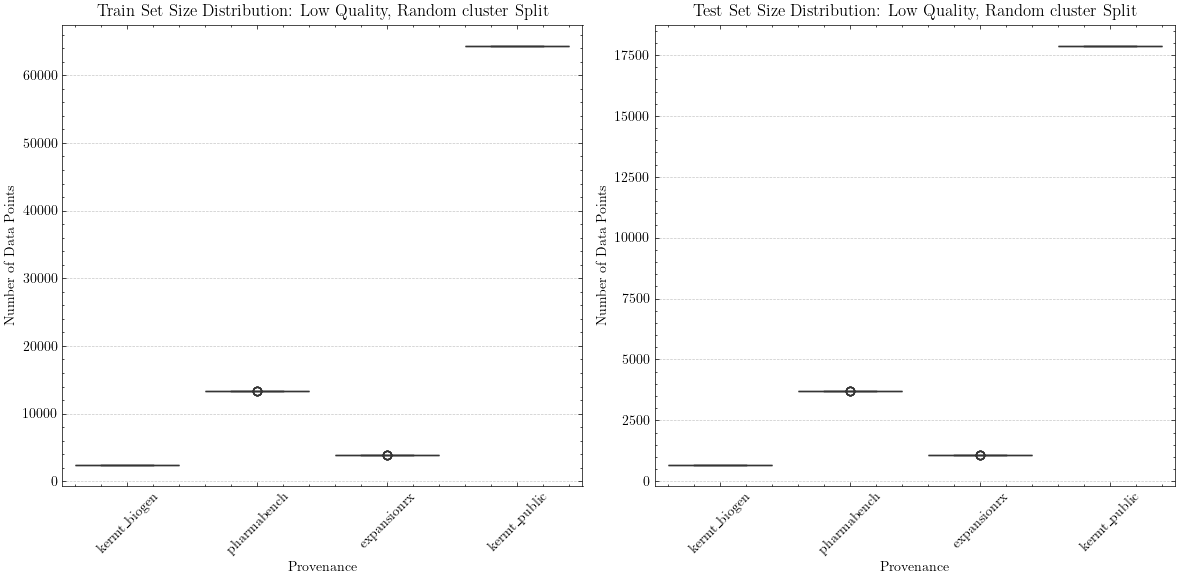

In [15]:
# boxplot distribution of data points for each split method and each dataset
for dset_name, splits in split_datasets.items():
    for split_name, split_data in splits.items():
        fold_sizes = []
        for split_id, folds in split_data.items():
            for fold_id, groups in folds.items():
                for group_name, datasets in groups.items():
                    # ignore "total"
                    if group_name == "total":
                        continue

                    train_size = len(datasets["train"])
                    test_size = len(datasets["test"])
                    fold_sizes.append(
                        {
                            "Split ID": split_id,
                            "Fold ID": fold_id,
                            "Group": group_name,
                            "Train Size": train_size,
                            "Test Size": test_size,
                        }
                    )
        fold_sizes_df = pd.DataFrame(fold_sizes)

        # 1 figure with 2 boxplots: train size and test size
        logger.info(
            f"Creating train/test size distribution boxplots for dataset: {dset_name}, split method: {split_name}"
        )
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        sns.boxplot(x="Group", y="Train Size", data=fold_sizes_df, ax=axs[0])
        axs[0].set_title(
            f"Train Set Size Distribution: {dset_name.capitalize()} Quality, {split_name.replace('_', ' ').capitalize()} Split"
        )

        sns.boxplot(x="Group", y="Test Size", data=fold_sizes_df, ax=axs[1])
        axs[1].set_title(
            f"Test Set Size Distribution: {dset_name.capitalize()} Quality, {split_name.replace('_', ' ').capitalize()} Split"
        )

        for ax in axs:
            ax.grid(True, axis="y", linestyle="--", alpha=0.7)
            ax.tick_params(axis="x", rotation=45)
            ax.set_ylabel("Number of Data Points")
            ax.set_xlabel("Provenance")

        fig.tight_layout()
        fig.savefig(
            output_fig_dir
            / f"{dset_name}_quality_{split_name}_split_train_test_size_distribution_boxplot.png",
            dpi=600,
        )